## Rice Field detection

In this project, we are going detect the rice field from satellite imagery.


### Dataset

Input data are 4 bands (RGB and NIR) satellite images. And output are binary images. Pixel value is 0 for non-rice bfield and pixel value is 1 for rice fields.



In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

## Data preprocessing

In [2]:
train_xx_initial = np.load('../UNet/data/X_train.npy')
train_yy_initial = np.load('../UNet/data/y_train.npy')
test_xx = np.load('../UNet/data/X_test.npy')
test_yy = np.load('../UNet/data/y_test.npy')
print(train_xx_initial.shape, train_yy_initial.shape, test_xx.shape, test_yy.shape)


(272, 256, 256, 3) (272, 256, 256, 1) (12, 256, 256, 3) (12, 256, 256, 1)


### Data Agumentation

In [3]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [4]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(train_xx_initial.shape[0]):
    image = train_xx_initial[i]
    mask = train_yy_initial[i]

    # Create a segmentation map object from the mask
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        # Apply the same augmentation to both image and mask
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)

        # Append the augmented image and mask to the lists
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

In [5]:
# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)

In [6]:
# release memory
del augmented_images
del augmented_masks

In [7]:
train_xx.max(), train_xx.min(), train_xx.dtype

(1.0, 0.0, dtype('float32'))

In [8]:
train_xx.shape, train_yy.shape

((1088, 256, 256, 3), (1088, 256, 256, 1))

In [9]:
num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)

train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

239


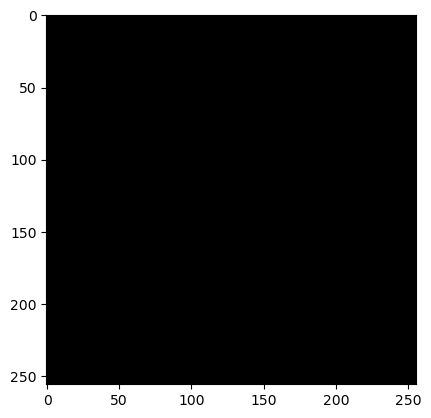

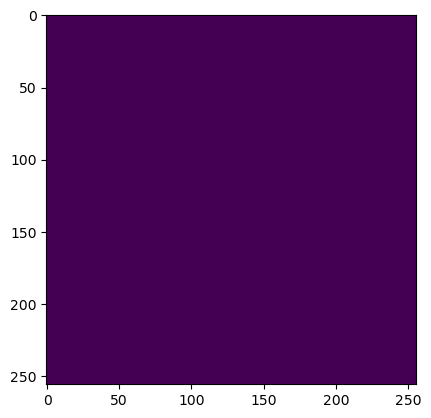

In [10]:
# Let's plot a sample input RGB image and output image with buildings
img = np.random.randint(0,264)
print(img)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

## U-Net model development
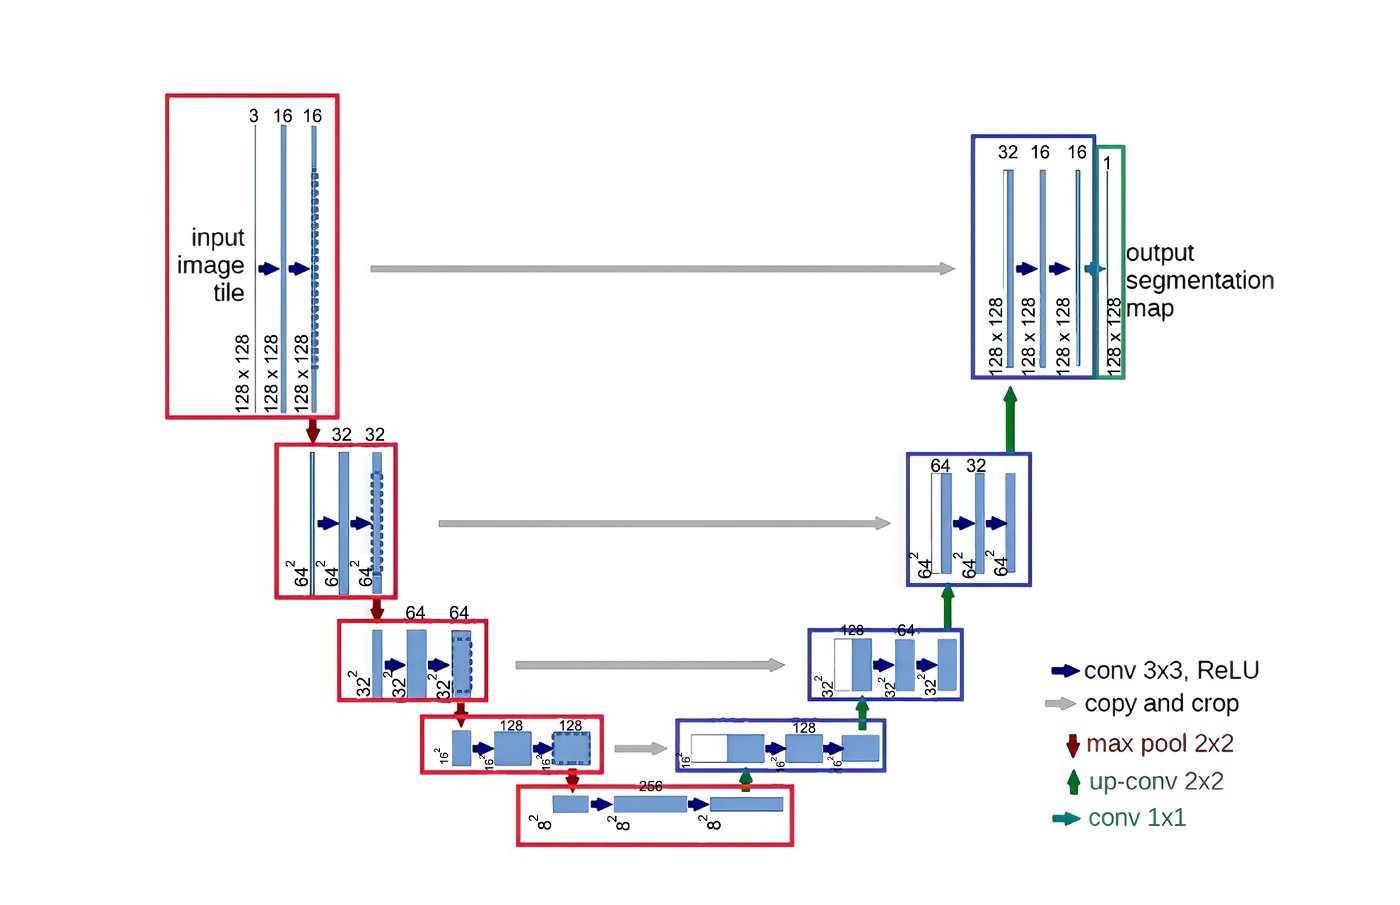


In [11]:
x_in = Input(shape=(256, 256, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [12]:
import tensorflow as tf

In [13]:
# training model

# callback function to stop overfitting the model
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_weight.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(train_xx, train_yy,
                    validation_data=(test_xx, test_yy),
                    epochs=100,
                    batch_size=64,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
17/17 [==============================] - 164s 9s/step - loss: 0.4586 - val_loss: 0.2113

Epoch 1: val_loss improved from inf to 0.21126, saving model to best_weight.h5
Epoch 2/100
17/17 [==============================] - 151s 9s/step - loss: 0.0962 - val_loss: 0.0878

Epoch 2: val_loss improved from 0.21126 to 0.08778, saving model to best_weight.h5
Epoch 3/100
17/17 [==============================] - 151s 9s/step - loss: 0.0504 - val_loss: 0.1073

Epoch 3: val_loss did not improve from 0.08778
Epoch 4/100
17/17 [==============================] - 150s 9s/step - loss: 0.0419 - val_loss: 0.1198

Epoch 4: val_loss did not improve from 0.08778
Epoch 5/100
17/17 [==============================] - 153s 9s/step - loss: 0.0389 - val_loss: 0.1067

Epoch 5: val_loss did not improve from 0.08778
Epoch 6/100
17/17 [==============================] - 151s 9s/step - loss: 0.0373 - val_loss: 0.0786

Epoch 6: val_loss improved from 0.08778 to 0.07856, saving model to best_weight.h5
Epoch 7/

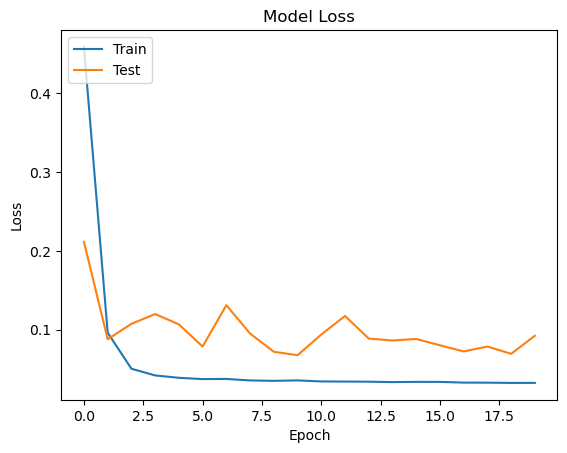

In [14]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [15]:
from tensorflow.keras.models import load_model
model = load_model('best_weight.h5')

1/1 [==============================] - 1s 756ms/step
(12, 256, 256, 1)


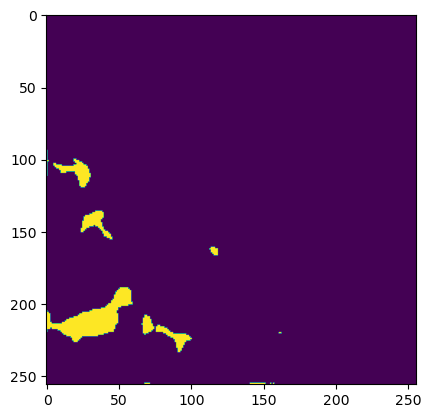

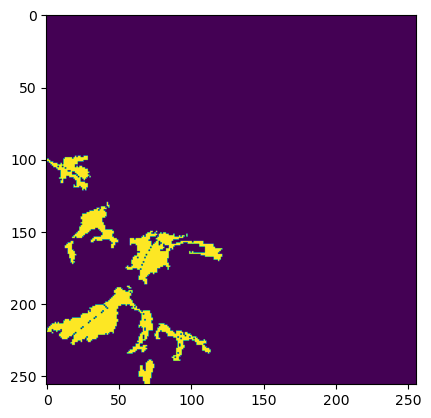

In [16]:
threshold = 0.3

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's compare random predicted and actual y values
img = np.random.randint(0, 12)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(test_yy[img,:,:,0])
plt.show()

In [17]:
threshold = 0.3

# prediction of the output
pred_train = model.predict(train_xx)
pred_train = (pred_train > threshold).astype(np.uint8)
print(pred_train.shape)


34/34 [==============================] - 44s 1s/step
(1088, 256, 256, 1)


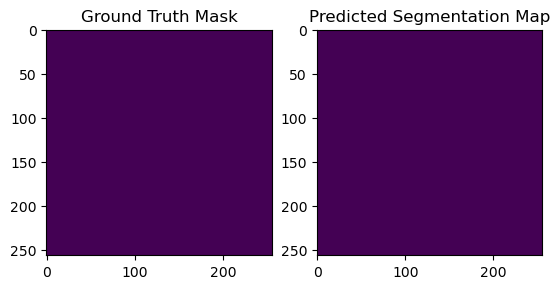

44


In [18]:
#let's comare random predicted and actial y values
fig, (ax1, ax2) = plt.subplots(1,2)
img = np.random.randint(10,111)
ax1.imshow(train_yy[img,:,:,0])
ax2.imshow(pred_train[img, :, :, 0])
ax1.set_title("Ground Truth Mask")
ax2.set_title('Predicted Segmentation Map')
plt.show()
print(img)


This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.

## Accuracy assessment

In image segmentation, the overall model accuracy is determined by following metrics,

1. Precision
2. recall
3. F1-Score
4. Intersection over Union (IoU)

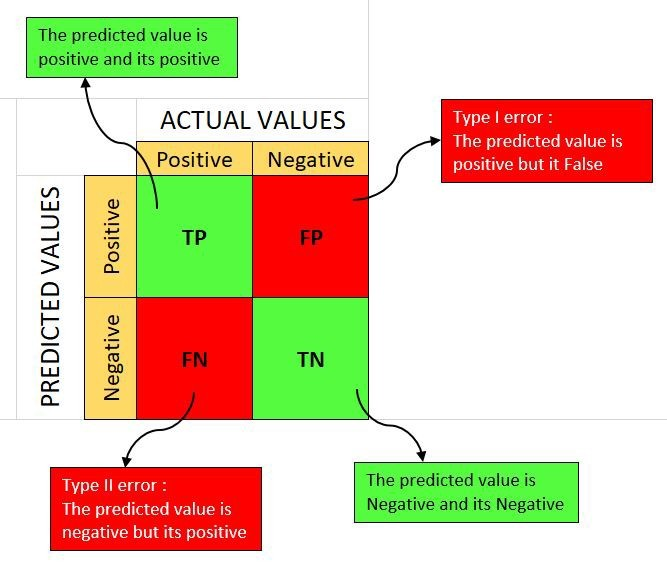


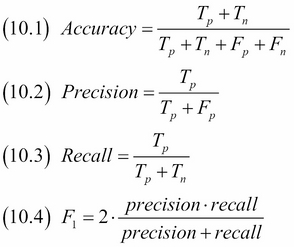

In [19]:
test_yy = test_yy.astype('uint8')
pred_test = pred_test.astype('uint8')

In [20]:
def calculate_metrics(ground_truth, predicted_mask):
    # Flatten the binary masks to 1D arrays
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    # True Positives, False Positives, False Negatives
    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))

    # True Negatives (optional, may not be needed for all cases)
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    # Calculate Precision, Recall, and F1 Score
    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate Intersection over Union (IoU)
    iou = TP / (TP + FP + FN)

    return accuracy, precision, recall, f1_score, iou

In [21]:
print(calculate_metrics(test_yy, pred_test))

(0.9747873942057291, 0.5307191063532697, 0.43679371767860564, 0.4791973103593192, 0.31509499136442143)


In [22]:
train_yy = train_yy.astype('uint8')
pred_train = pred_train.astype('uint8')

In [23]:
print(calculate_metrics(train_yy, pred_train))

(0.9821690811830408, 0.572739120867961, 0.8543918078379303, 0.6857725567500891, 0.5218066022531564)


## Merge prediction

Merging the prediction mask tiles as a single image.

In [24]:
from geotile import GeoTile

In [25]:
gt = GeoTile('../UNet/data/Pidie_2022-06_test.tif')
gt.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 495,
 'height': 356,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0003661351407767156, 0.0, 95.72397299000005,
        0.0, -0.00036462728799999654, 5.568995350000023)}

In [26]:
gt.generate_tiles(save_tiles=False, stride_x=256, stride_y=256)
gt.convert_nan_to_zero()
gt.normalize_tiles()

In [27]:
gt.tile_data.shape, gt.tile_data.max(), gt.tile_data.min(), gt.tile_data.dtype

((4, 256, 256, 3), 1.0, 0.0, dtype('float32'))

In [28]:
threshold = 0.3

# prediction of the output
pred_test = model.predict(gt.tile_data)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

1/1 [==============================] - 0s 206ms/step
(4, 256, 256, 1)


In [29]:
gt.tile_data = pred_test

In [30]:
gt.save_tiles("prediction_tiles/")

In [31]:
from geotile import mosaic

mosaic('prediction_tiles/', 'pred_merged.tif')

'pred_merged.tif'

Training Image Merge

In [32]:
gt2 = GeoTile('../UNet/data/Pidie_2022-06_train.tif')
gt2.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 2007,
 'height': 2144,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00036613514077670303, 0.0, 95.74337815246122,
        0.0, -0.0003646272879999966, 5.439188035472024)}

In [33]:
gt2.generate_tiles(save_tiles=False, stride_x=256, stride_y=256)
gt2.convert_nan_to_zero()
gt2.normalize_tiles()

In [34]:
gt2.tile_data.shape, gt2.tile_data.max(), gt2.tile_data.min(), gt2.tile_data.dtype

((72, 256, 256, 3), 1.0, 0.0, dtype('float32'))

In [35]:
threshold = 0.3

# prediction of the output
pred_train = model.predict(gt2.tile_data)
pred_train = (pred_train > threshold).astype(np.uint8)
print(pred_train.shape)

3/3 [==============================] - 3s 834ms/step
(72, 256, 256, 1)


In [36]:
gt2.tile_data = pred_train

In [37]:
gt2.save_tiles("prediction_train_tiles/")

In [38]:
from geotile import mosaic

mosaic('prediction_train_tiles/', 'pred_train_merged.tif')

'pred_train_merged.tif'